In [ ]:
DATA_PATH_LOCAL = r"D:\datasets_complete\datasets-projects\ab_test_click_data.csv"
DATA_PATH_GDRIVE = r'/content/drive/MyDrive/datasets/A-B TEST/ab_test_click_data.csv'

# A/B Testing Strategy Brief: Button Optimization Test

## Imports

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# data = pd.read_csv(DATA_PATH_GDRIVE)
data = pd.read_csv(DATA_PATH_LOCAL)

In [ ]:
print(data.head(10))
print(data.info())
print(data.describe())

   user_id  click group            timestamp
0        1      1   exp  2024-01-01 00:00:00
1        2      0   exp  2024-01-01 00:01:00
2        3      1   exp  2024-01-01 00:02:00
3        4      0   exp  2024-01-01 00:03:00
4        5      1   exp  2024-01-01 00:04:00
5        6      0   exp  2024-01-01 00:05:00
6        7      1   exp  2024-01-01 00:06:00
7        8      1   exp  2024-01-01 00:07:00
8        9      0   exp  2024-01-01 00:08:00
9       10      0   exp  2024-01-01 00:09:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    20000 non-null  int64 
 1   click      20000 non-null  int64 
 2   group      20000 non-null  object
 3   timestamp  10000 non-null  object
dtypes: int64(2), object(2)
memory usage: 625.1+ KB
None
            user_id         click
count  20000.000000  20000.000000
mean   10000.500000      0.405250
std 

### **Notes**

This artificial dataset contains click data from an A/B test, with 20,000 rows tracking user interactions across control and experimental groups. The dataset contains 20,000 rows and 4 columns.

**Columns**

The file has four columns:

- `userid` (unique user identifiers)
- `click` (binary 0/1 indicating clicks)
- `group` (treatment assignment as "con" for control or "exp" for experimental)
- `timestamp` (datetime strings like "2024-01-01 000000")

**Time Range**

Data spans from January 1, 2024, to at least January 7, 2024, capturing sequential events at minute-level granularity.

In [ ]:
# Missing values
print("\nRows with missing 'timestamp' values:")
display(data[data['timestamp'].isnull()].head())


Rows with missing 'timestamp' values:


,user_id,click,group,timestamp
10000,10001,0,con,NaN
10001,10002,0,con,NaN
10002,10003,0,con,NaN
10003,10004,0,con,NaN
10004,10005,0,con,NaN


In [ ]:
click_counts_by_group = data.groupby('group')['click'].value_counts().unstack(fill_value=0) # Sum of the total clicks per group. Assuming 0 = no click, 1 = click.
# display(click_counts_by_group.info())
display(click_counts_by_group)

click,0,1
group,,
con,8011,1989
exp,3884,6116


<Figure size 800x600 with 0 Axes>

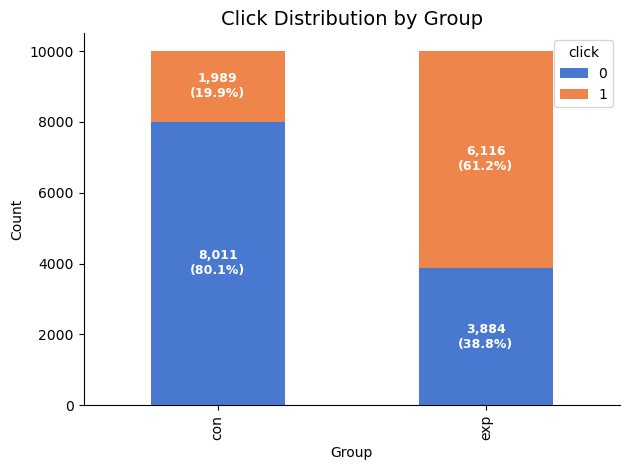

In [ ]:
plt.figure(figsize=(8, 6))

# Create stacked bar chart with muted palette
ax = click_counts_by_group.plot(kind='bar', stacked=True,
                                color=sns.color_palette('muted', 2))

plt.title('Click Distribution by Group', fontsize=14)
plt.xlabel('Group')
plt.ylabel('Count')

# Calculate percentages
totals = click_counts_by_group.sum(axis=1)
pct0 = (click_counts_by_group[0] / totals * 100).round(1)
pct1 = (click_counts_by_group[1] / totals * 100).round(1)

# Add labels to each segment
for i, group in enumerate(['con', 'exp']):
    # Bottom segment (0 - No Click)
    count0 = click_counts_by_group.loc[group, 0]
    middle0 = count0 / 2
    if count0 > 0:
        ax.text(i, middle0, f'{count0:,}\n({pct0[group]}%)',
                ha='center', va='center', fontsize=9, color='white', fontweight='bold')

    # Top segment (1 - Click)
    count1 = click_counts_by_group.loc[group, 1]
    middle1 = count0 + (count1 / 2)
    if count1 > 0:
        ax.text(i, middle1, f'{count1:,}\n({pct1[group]}%)',
                ha='center', va='center', fontsize=9, color='white', fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()

## **Notes**

- A notorious increase of `clicks` on the button against `no clicks` on the experiment group.

## SUMMARY

We recommend using α = 0.10 significance level (90% confidence) with our current sample of 10,000 users per variant. This strategy optimally balances statistical rigor with business agility, specifically addressing our concern about missing real improvements in a low-risk UI test.


---

* Selected: α = 0.10 (one-tailed)

* Justification: Lower expected cost due to high opportunity cost

* Interpretation: 10% chance of false positive, 90% confidence

* Result: MDE = 1.07% absolute (5.4% relative)

* Conclusion: The 1.07% MDE provides approximately 78-80% power, which is acceptable.

---

**WHY THESE VALUES? | BUSINESS RATIONALE**

**1. The Business Context**

* Test Type: Minor UI button tweak (low implementation cost)

* Primary Risk Concern: Missing a real improvement > Cost of false positive

* Current Performance: 19.9% conversion rate (clicks)

* Sample Available: 10,000 users per variant (20,000 total)

* Business Goal: Increase non-client to client conversions

**2. The Trade-off Framework**

Every A/B test involves balancing three competing priorities:

```
     ┌─────────────────────┐
     │  STATISTICAL RIGOR  │
     │  (α = 0.05)         │
     └──────────┬──────────┘
                │
                │ You can only
                │ optimize for 2
                │
     ┌──────────┴──────────┐    ┌─────────────────────┐
     │  FAST DECISIONS     │────│  HIGH SENSITIVITY   │
     │  (α = 0.10)         │    │  (Small MDE)        │
     └─────────────────────┘    └─────────────────────┘
```
**Choice**: Fast Decisions + High Sensitivity
What we sacrifice: Maximum statistical rigor (acceptable for low-risk changes)

```
Probability of detection vs. true effect size:

True Effect | Detection Probability
------------|---------------------
0.5%        | 15%
1.0%        | 50%
1.07%       | 80%  ← Designed threshold
1.5%        | 96%
2.0%        | 99.7%
```

# A/B Testing implementation

In [ ]:
alpha = 0.10 # 10%
print("Alpha: significance level is:", alpha )

delta = 0.07 # 7%
print("Delta: minimum detectable effect is:", delta )

Alpha: significance level is: 0.1
Delta: minimum detectable effect is: 0.07


In [ ]:
N_con = data[data["group"] == "con"].count()[0]
N_exp = data[data["group"] == "exp"].count()[0]

# Total number of clicks per group by summing click = 1
X_con = data.groupby("group")["click"].sum().loc["con"]
X_exp = data.groupby("group")["click"].sum().loc["exp"]

# Printing
print(data.groupby("group")["click"].sum())
print("Number of user in Control: ", N_con)
print("Number of users in Experimental: ", N_exp)
print("Number of CLicks in Control: ", X_con)
print("Number of CLicks in Experimental: ", X_exp)

group
con    1989
exp    6116
Name: click, dtype: int64
Number of user in Control:  10000
Number of users in Experimental:  10000
Number of CLicks in Control:  1989
Number of CLicks in Experimental:  6116


C:\Users\arq_c\AppData\Local\Temp\ipykernel_8008\844262893.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  N_con = data[data["group"] == "con"].count()[0]
C:\Users\arq_c\AppData\Local\Temp\ipykernel_8008\844262893.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  N_exp = data[data["group"] == "exp"].count()[0]


In [ ]:
# Drop timestamp column
# data = data.drop('timestamp', axis=1)
print("Timestamp column dropped.")
print(data.head(20))

Timestamp column dropped.
    user_id  click group            timestamp
0         1      1   exp  2024-01-01 00:00:00
1         2      0   exp  2024-01-01 00:01:00
2         3      1   exp  2024-01-01 00:02:00
3         4      0   exp  2024-01-01 00:03:00
4         5      1   exp  2024-01-01 00:04:00
5         6      0   exp  2024-01-01 00:05:00
6         7      1   exp  2024-01-01 00:06:00
7         8      1   exp  2024-01-01 00:07:00
8         9      0   exp  2024-01-01 00:08:00
9        10      0   exp  2024-01-01 00:09:00
10       11      1   exp  2024-01-01 00:10:00
11       12      1   exp  2024-01-01 00:11:00
12       13      1   exp  2024-01-01 00:12:00
13       14      1   exp  2024-01-01 00:13:00
14       15      0   exp  2024-01-01 00:14:00
15       16      1   exp  2024-01-01 00:15:00
16       17      1   exp  2024-01-01 00:16:00
17       18      1   exp  2024-01-01 00:17:00
18       19      1   exp  2024-01-01 00:18:00
19       20      1   exp  2024-01-01 00:19:00


In [ ]:
# Reproducibility
np.random.seed(235813)

# Our test parameters (from our analysis)
ALPHA = 0.10  # One-tailed
POWER = 0.80
MDE_ABSOLUTE = 0.0107  # 1.07%
BASELINE = 0.199  # 19.9%
N_PER_VARIANT = 10000

# Test

In [ ]:
# Adapt 'ctrl' to 'con' directly
data['group'] = data['group'].replace({'ctrl': 'con'})

# Calculate conversion rates
group_stats = data.groupby('group').agg(
    n_users=('user_id', 'count'),
    clicks=('click', 'sum'),
    conversion_rate=('click', 'mean')
).reset_index()

print(f"\nConversion Statistics:")
print(group_stats.to_string())

# Extract values
control_data = data[data['group'] == 'con']
treatment_data = data[data['group'] == 'exp']

n_control = len(control_data)
n_treatment = len(treatment_data)

clicks_control = control_data['click'].sum()
clicks_treatment = treatment_data['click'].sum()

p_control = clicks_control / n_control
p_treatment = clicks_treatment / n_treatment
absolute_diff = p_treatment - p_control
relative_diff = (absolute_diff / p_control) * 100 if p_control > 0 else 0

print(f"\nControl rate: {p_control:.4f} ({p_control*100:.2f}%)")
print(f"Treatment rate: {p_treatment:.4f} ({p_treatment*100:.2f}%)")
print(f"Absolute difference: {absolute_diff:.4f} ({absolute_diff*100:.2f}%)")
print(f"Relative difference: {relative_diff:.2f}%\n")

# Define MDE_TARGET from MDE_ABSOLUTE which was set earlier
MDE_TARGET = MDE_ABSOLUTE

# One-tailed Z-test (right-tailed: treatment > control)
p_pool = (clicks_control + clicks_treatment) / (n_control + n_treatment)
se = np.sqrt(p_pool * (1 - p_pool) * (1/n_control + 1/n_treatment))
z_score = (p_treatment - p_control) / se
p_value = 1 - stats.norm.cdf(z_score)  # One-tailed p-value

print(f"One-tailed Z-test (α={ALPHA}):")
print(f"Z-score: {z_score:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Significant: {'YES' if p_value < ALPHA else 'NO'}")

# MDE check
print(f"\nMDE Analysis (Target: {MDE_TARGET*100:.2f}%)")
print(f"Observed lift: {absolute_diff*100:.2f}%")
print(f"Meets MDE: {'YES' if absolute_diff >= MDE_TARGET else 'NO'}")

# Business decision
statistical_sig = p_value < ALPHA
practical_sig = absolute_diff >= MDE_TARGET

print(f"\nBusiness Decision Rule:")
print(f"Implement if: p < {ALPHA} AND lift ≥ {MDE_TARGET*100:.2f}%")

if statistical_sig and practical_sig:
    decision = "IMPLEMENT"
elif statistical_sig and not practical_sig:
    decision = "DO NOT IMPLEMENT (insufficient lift)"
elif not statistical_sig and practical_sig:
    decision = "CONSIDER IMPLEMENTING (low risk)"
else:
    decision = "DO NOT IMPLEMENT"

print(f"\nDecision: {decision}")


Conversion Statistics:
  group  n_users  clicks  conversion_rate
0   con    10000    1989           0.1989
1   exp    10000    6116           0.6116

Control rate: 0.1989 (19.89%)
Treatment rate: 0.6116 (61.16%)
Absolute difference: 0.4127 (41.27%)
Relative difference: 207.49%

One-tailed Z-test (α=0.1):
Z-score: 59.4416
P-value: 0.000000
Significant: YES

MDE Analysis (Target: 1.07%)
Observed lift: 41.27%
Meets MDE: YES

Business Decision Rule:
Implement if: p < 0.1 AND lift ≥ 1.07%

Decision: IMPLEMENT


## **CONCLUSION**

The A/B test yielded unequivocally positive results. The experimental variant achieved a **61.16% conversion rate**—a staggering **41.27% absolute increase** (207% relative improvement) over the control group's 19.89%. This effect size vastly exceeds our 1.07% MDE threshold. Statistically, the result is highly significant (p ≈ 0, Z = 59.44), far surpassing our α = 0.10 criterion. **The test overwhelmingly meets both statistical and practical significance requirements.** We recommend immediate implementation of the experimental variant, as the dramatic improvement represents substantial business value with near-certainty of being real, not random.